In [1]:
# import libraries 
import lxml
import pandas as pd 
import numpy as np
import re 
from tqdm import tqdm  # controlar el tiempo en un loop
import os
import matplotlib.pyplot as plt
import seaborn as sns



# linear model library

import statsmodels.api as sm  # linear regression utiliza todas las columnas de base de datos 
import statsmodels.formula.api as smf  # linear regression usa uan formula
from sklearn import datasets, linear_model # models 
from sklearn.metrics import mean_squared_error, r2_score
from linearmodels.iv import IV2SLS # for IV regression

import warnings
warnings.filterwarnings('ignore') # eliminar warning messages 


# Export latex table 

from pystout import pystout

# 1. Regresiones lineales

## 1.1 Estadísticas descriptivas

In [2]:
# laod dataset

dataSP = pd.read_stata(r"../../data/trabajo_final/replicacion/SerraPorterAEJ.dta")
dataSP

,anonid,took_fall,took_year,tookanother,numeconclass,econmajor,Major,Major_STEM,Major_Business,Major_Finance,...,ecojobs_b,ecojobs_c,ecojobs_d,ecojobs_e,ecojobs_f,ecojobs_g,ecojobs_h,major_current_a,major_current_b,survey_econmajor
0,4.0,0.0,0.0,0.0,0.0,0.0,Mathematics - BS,1.0,0.0,0.0,...,Entrepreneur,Journalist/ Correspondent,Working for marketplace on NPR,Business consultant,,,,Mathematics,,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,Biological Sciences - BS,1.0,0.0,0.0,...,Tax advisor,Managerial Position,,,,,,Biology,,0.0
2,7.0,1.0,1.0,1.0,13.0,1.0,Economics w/ Fina Appl - BS,0.0,0.0,0.0,...,,,,,,,,,,NaN
3,9.0,0.0,0.0,0.0,0.0,0.0,Journalism - BA,0.0,0.0,0.0,...,,,,,,,,Journalism,Communications,0.0
4,10.0,0.0,0.0,1.0,1.0,0.0,Markets & Culture - BA,0.0,0.0,0.0,...,Investment Banker,,,,,,,Markets and Culture,Economics,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,1386.0,0.0,0.0,0.0,0.0,0.0,Markets & Culture - BA,0.0,0.0,0.0,...,,,,,,,,,,NaN
623,1388.0,0.0,0.0,0.0,0.0,0.0,Economics w/ Fina Appl - PMJ,0.0,0.0,0.0,...,,,,,,,,Business,,0.0
624,1389.0,0.0,0.0,0.0,0.0,0.0,Accounting - BBA,0.0,1.0,0.0,...,Finance,Bank,Government,,,,,Economics,Public Relations,1.0
625,1393.0,0.0,1.0,1.0,10.0,1.0,Economics - BA,0.0,0.0,0.0,...,Professor,Economist,,,,,,Entrepreneurship,Finance Economics,0.0


In [3]:
# Seleccionamos las variables para las estadísticas descriptivas

table1 = dataSP.loc[:,["american", "instate", "freshman","ACumGPA", "greek", "econ_hs",
                        "varsity"]]

table1 

,american,instate,freshman,ACumGPA,greek,econ_hs,varsity
0,1.0,1.0,0.0,3.267,0.0,1.0,0.0
1,1.0,1.0,0.0,3.358,0.0,1.0,0.0
2,1.0,0.0,1.0,1.775,NaN,NaN,NaN
3,1.0,1.0,0.0,3.654,1.0,1.0,0.0
4,1.0,1.0,0.0,3.000,1.0,1.0,0.0
...,...,...,...,...,...,...,...
622,1.0,0.0,1.0,2.653,NaN,NaN,NaN
623,0.0,0.0,1.0,3.200,0.0,0.0,0.0
624,0.0,0.0,1.0,3.677,0.0,0.0,1.0
625,0.0,0.0,1.0,3.500,0.0,0.0,0.0


In [4]:
summary_table = table1.describe().loc[["mean","std","min","max","count"]].T
summary_table
# .t permite tranponer el DataFrame

,mean,std,min,max,count
american,0.902711,0.296587,0.0,1.0,627.0
instate,0.221691,0.415717,0.0,1.0,627.0
freshman,0.864434,0.342602,0.0,1.0,627.0
ACumGPA,3.432091,0.435175,1.2,4.0,627.0
greek,0.642715,0.479679,0.0,1.0,501.0
econ_hs,0.578842,0.494239,0.0,1.0,501.0
varsity,0.072000,0.258747,0.0,1.0,500.0


In [5]:
table1.columns

new_names = ["American student","In-state-student","Freshman",
"Cumulative GPA","Belongs to soroty","Took econ in high school","Athlete"]

# unión de listas bajo la estructura diccionario

dict( zip( table1.columns, new_names) )

{'american': 'American student',
 'instate': 'In-state-student',
 'freshman': 'Freshman',
 'ACumGPA': 'Cumulative GPA',
 'greek': 'Belongs to soroty',
 'econ_hs': 'Took econ in high school',
 'varsity': 'Athlete'}

In [6]:
# Customize summary table 

index_nuevos_nombres = dict( zip( table1.columns, new_names) )

columns_nuevos_nombres = {
    "mean": "Mean",
    "std": "Standard Deviation",
    "count": "Observations",
    "min": "Min",
    "max": "Max",
}

# Rename
summary_table.rename(index=index_nuevos_nombres, columns=columns_nuevos_nombres, inplace=True)
summary_table

,Mean,Standard Deviation,Min,Max,Observations
American student,0.902711,0.296587,0.0,1.0,627.0
In-state-student,0.221691,0.415717,0.0,1.0,627.0
Freshman,0.864434,0.342602,0.0,1.0,627.0
Cumulative GPA,3.432091,0.435175,1.2,4.0,627.0
Belongs to soroty,0.642715,0.479679,0.0,1.0,501.0
Took econ in high school,0.578842,0.494239,0.0,1.0,501.0
Athlete,0.072000,0.258747,0.0,1.0,500.0


In [7]:
# Export the DataFrame to LaTeX
# \ permite esccribir código extenso en lineas diferentes

summary_table.style.format(subset="Mean", precision=2).format(subset="Standard Deviation", precision=2)\
.format(subset="Min", precision=0)\
.format(subset="Max", precision=0).format(subset="Observations", precision=0)\
.to_latex(
    r"..\..\Trabajo_final\Grupo2\summary_py.tex",
caption="Descriptive Statistics",
    column_format = "lccccc"   # l: left, c:center , r: right
) 


## 1.2 Replicar las tablas 3 (p. 239), 4 (p. 241), 5 (p. 243) y 6 (p. 244)

### Tabla 3

In [8]:
#Tabla 3

control_vars = ["female_prof", "instate", "freshman", "american", "ACumGPA", "gradePrinciples","small_class"]

formula_model1 = "took_year ~ yr_2016 + treatment_class + treat2016"
formula_model2 = "took_year ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )
formula_model3 = "tookanother ~ yr_2016 + treatment_class + treat2016"
formula_model4 = "tookanother ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )


ols_model1 = smf.ols(formula_model1, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model2 = smf.ols(formula_model2, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model3 = smf.ols(formula_model3, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model4 = smf.ols(formula_model4, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})




print(ols_model1.summary())

                            OLS Regression Results                            
Dep. Variable:              took_year   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     16.50
Date:                Sat, 15 Jul 2023   Prob (F-statistic):           0.000220
Time:                        21:12:56   Log-Likelihood:                -211.88
No. Observations:                 627   AIC:                             431.8
Df Residuals:                     623   BIC:                             449.5
Df Model:                           3                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1474      0.014     

In [9]:
# Lista de explicativa a mostrarse en la tabla

explicativas = ['treat2016','yr_2016','treatment_class','Intercept']

# etiquetas a las variables 

etiquetas = ['Treatment class x 2016', 'Year 2016','Treatment class (in 2015)','Constant']


labels = dict(zip(explicativas,etiquetas))
labels 

{'treat2016': 'Treatment class x 2016',
 'yr_2016': 'Year 2016',
 'treatment_class': 'Treatment class (in 2015)',
 'Intercept': 'Constant'}

In [10]:
pystout(models = [ols_model1,ols_model2,ols_model3,ols_model4], file=r"..\..\Trabajo_final\Grupo2\regression_table_py.tex", digits=3,
        endog_names=['Took Micro within year','Took Micro within year','Took another econ class','Took another econ class'],
        exogvars =explicativas ,  # sellecionamos las variables 
        varlabels = labels,  # etiquetas a las variables
        modstat={'nobs':'Observations'}, # estadísticos 
        addrows={'Controls':['No','Yes','No','Yes']}, # añadimos filas 
        addnotes=['Notes: LPM regressions. Standard errors are clustered at the class level (12 clusters). In columns 1 and 2, the dependent variable is a dummy equal to one if the student took Intermediate Micro the year after the Principles class. In columns 3 and 4, the dependent variable is a dummy equal to one if the student enrolled in another economics class at any time after the Principles class (up to January 2019).',
                 '* Significantly different from zero at 90 percent confidence.',
                 '** Significantly different from zero at 95 percent confidence.',
                 '*** Significantly different from zero at 99 percent confidence.'],
        title='TREATMENT EFFECTS ON INTERMEDIATE OUTCOMES',
        stars={.1:'*',.05:'**',.01:'***'}
       )



### Tabla 4

In [11]:

formula_model5 = "numeconclass ~ yr_2016 + treatment_class + treat2016"
formula_model6 = "numeconclass ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )
formula_model7 = "econmajor ~ yr_2016 + treatment_class + treat2016"
formula_model8 = "econmajor ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )


ols_model5 = smf.ols(formula_model5, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model6 = smf.ols(formula_model6, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model7 = smf.ols(formula_model7, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model8 = smf.ols(formula_model8, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})



print(ols_model5.summary())

                            OLS Regression Results                            
Dep. Variable:           numeconclass   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.964
Date:                Sat, 15 Jul 2023   Prob (F-statistic):             0.0385
Time:                        21:13:02   Log-Likelihood:                -1505.4
No. Observations:                 627   AIC:                             3019.
Df Residuals:                     623   BIC:                             3037.
Df Model:                           3                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0256      0.112     

In [12]:
pystout(models = [ols_model5,ols_model6,ols_model7,ols_model8], file=r"..\..\Trabajo_final\Grupo2\regression_table_py2.tex", digits=3,
        endog_names=['Number of econ classes taken','Number of econ classes taken','Major in economics','Major in economics'],
        exogvars =explicativas ,  # sellecionamos las variables 
        varlabels = labels,  # etiquetas a las variables
        modstat={'nobs':'Observations'}, # estadísticos 
        addrows={'Controls':['No','Yes','No','Yes']}, # añadimos filas 
        addnotes=['Notes: Columns 1-2, OLS regressions; columns 3-4, LPM regressions. Standard errors are clustered at the class level (12 clusters). In columns 1 and 2, the dependent variable is the number of economics classes taken after the Principles class. In columns 3 and 4, the dependent variable is a dummy equal to one if the student majored in economics (or declared the economics major, if the student has not graduated yet).',
                 '* Significantly different from zero at 90 percent confidence.',
                 '** Significantly different from zero at 95 percent confidence.',
                 '*** Significantly different from zero at 99 percent confidence.'],
        title='TREATMENT EFFECTS ON FINAL OUTCOMES',
        stars={.1:'*',.05:'**',.01:'***'}
       )



### Tabla 5

In [13]:
formula_model9 = "Major_STEM ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )
formula_model10 = "Major_Business ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )
formula_model11 = "Major_Finance ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )
formula_model12 = "Major_Marketing ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )


ols_model9 = smf.ols(formula_model9, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model10 = smf.ols(formula_model10, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model11 = smf.ols(formula_model11, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model12 = smf.ols(formula_model12, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})



print(ols_model9.summary())

                            OLS Regression Results                            
Dep. Variable:             Major_STEM   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     6.932
Date:                Sat, 15 Jul 2023   Prob (F-statistic):            0.00179
Time:                        21:13:06   Log-Likelihood:                -159.54
No. Observations:                 627   AIC:                             341.1
Df Residuals:                     616   BIC:                             389.9
Df Model:                          10                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2453      0.142     

In [14]:
pystout(models = [ols_model9,ols_model10,ols_model11,ols_model12], file=r"..\..\Trabajo_final\Grupo2\regression_table_py3.tex", digits=3,
        endog_names=['Major STEM','Major finance','Major business','Major marketing'],
        exogvars =explicativas ,  # sellecionamos las variables 
        varlabels = labels,  # etiquetas a las variables
        modstat={'nobs':'Observations'}, # estadísticos 
        addrows={'Controls':['Yes','Yes','Yes','Yes']}, # añadimos filas 
        addnotes=['Notes: LPM regressions. Standard errors are clustered at the class level (12 clusters). Dependent variables: dummy equal to one if the student majored in (i) STEM subjects, (ii) finance, (iii) business, or (iv) marketing.',
                 '* Significantly different from zero at 90 percent confidence.',
                 '** Significantly different from zero at 95 percent confidence.',
                 '*** Significantly different from zero at 99 percent confidence.'],
        title='TREATMENT EFFECTS ON OTHER HIGH-EARNING MAJORS',
        stars={.1:'*',.05:'**',.01:'***'}
       )



### Tabla 6

In [14]:
formula_model13 = "Major_SocSc ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )
formula_model14 = "Major_Arts ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )
formula_model15 = "Major_Comm ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )
formula_model16 = "Major_Hum ~ yr_2016 + treatment_class + treat2016 +" + ' + '.join( control_vars )


ols_model13 = smf.ols(formula_model13, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model14 = smf.ols(formula_model14, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model15 = smf.ols(formula_model15, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})
ols_model16 = smf.ols(formula_model16, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']})



print(ols_model13.summary())

                            OLS Regression Results                            
Dep. Variable:            Major_SocSc   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1483.
Date:                Sat, 15 Jul 2023   Prob (F-statistic):           9.97e-16
Time:                        21:13:09   Log-Likelihood:                -131.82
No. Observations:                 627   AIC:                             285.6
Df Residuals:                     616   BIC:                             334.5
Df Model:                          10                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6238      0.156     

In [15]:
pystout(models = [ols_model13,ols_model14,ols_model15,ols_model16], file=r"..\..\Trabajo_final\Grupo2\regression_table_py4.tex", digits=3,
        endog_names=['Major social sciences','Major arts','Major communication','Major humanities'],
        exogvars =explicativas ,  # sellecionamos las variables 
        varlabels = labels,  # etiquetas a las variables
        modstat={'nobs':'Observations'}, # estadísticos 
        addrows={'Controls':['Yes','Yes','Yes','Yes']}, # añadimos filas 
        addnotes=['Notes: LPM regressions. Standard errors are clustered at the class level (12 clusters). Dependent variables: dummy equal to one if the student majored in (i) social science (other than economics), (ii) arts, (iii) communication studies, or (iv) humanities.',
                 '* Significantly different from zero at 90 percent confidence.',
                 '** Significantly different from zero at 95 percent confidence.',
                 '*** Significantly different from zero at 99 percent confidence.'],
        title='TREATMENT EFFECTS ON LOW-EARNING MAJORS',
        stars={.1:'*',.05:'**',.01:'***'}
       )



In [16]:
ols_model5 = smf.ols(formula_model5, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']}).summary2().tables[1]
ols_model6 = smf.ols(formula_model6, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']}).summary2().tables[1]
ols_model7 = smf.ols(formula_model7, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']}).summary2().tables[1]
ols_model8 = smf.ols(formula_model8, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']}).summary2().tables[1]

## 1.3 Graficar con coefplot


In [17]:

ols_model5 = smf.ols(formula_model5, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']}).summary2().tables[1]
ols_model5_coef = ols_model5.iloc[3,0]  # fila posición 1 y columan posición 0
ols_model5_coef_se = ols_model5.iloc[3,1] # fila posición 1 y columan posición 1

ols_model5_lower = ols_model5.iloc[3,4]
ols_model5_upper = ols_model5.iloc[3,5]

ols_model6 = smf.ols(formula_model6, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']}).summary2().tables[1]
ols_model6_coef = ols_model6.iloc[3,0]  # fila posición 1 y columan posición 0
ols_model6_coef_se = ols_model6.iloc[3,1] # fila posición 1 y columan posición 1

ols_model6_lower = ols_model6.iloc[3,4]
ols_model6_upper = ols_model6.iloc[3,5]

ols_model7 = smf.ols(formula_model7, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']}).summary2().tables[1]
ols_model7_coef = ols_model7.iloc[3,0]  # fila posición 1 y columan posición 0
ols_model7_coef_se = ols_model7.iloc[3,1] # fila posición 1 y columan posición 1

ols_model7_lower = ols_model7.iloc[3,4]
ols_model7_upper = ols_model7.iloc[3,5]

ols_model8 = smf.ols(formula_model8, data=dataSP).fit(cov_type='cluster', cov_kwds={'groups': dataSP['class_fe2']}).summary2().tables[1]
ols_model8_coef = ols_model8.iloc[3,0]  # fila posición 1 y columan posición 0
ols_model8_coef_se = ols_model8.iloc[3,1] # fila posición 1 y columan posición 1

ols_model8_lower = ols_model8.iloc[3,4]
ols_model8_upper = ols_model8.iloc[3,5]


table = np.zeros( ( 4, 4 ) )  # creación de tablas vacías

# completamos la información de coeficiente estimado e intervalo de confianza

table[0,0] = ols_model5_coef
table[0,1] = ols_model5_coef_se 
table[0,2] = ols_model5_lower
table[0,3] = ols_model5_upper 

table[1,0] = ols_model6_coef
table[1,1] = ols_model6_coef_se  
table[1,2] = ols_model6_lower
table[1,3] = ols_model6_upper 

table[2,0] = ols_model7_coef
table[2,1] = ols_model7_coef_se  
table[2,2] = ols_model7_lower
table[2,3] = ols_model7_upper 

table[3,0] = ols_model8_coef
table[3,1] = ols_model8_coef_se  
table[3,2] = ols_model8_lower
table[3,3] = ols_model8_upper 

# dataframe 

table_pandas = pd.DataFrame( table, columns = [ "Estimate","Std. Error","Lower_bound" , "Upper_bound"])
table_pandas.index = [ "Number of econ classes","Number of econ classes using control variables", "Major in economics", "Major in economics using control variables"]

table_pandas.reset_index(inplace = True)
table_pandas.rename(columns = {"index" : "Model"}, inplace = True)

table_pandas.round(8)

,Model,Estimate,Std. Error,Lower_bound,Upper_bound
0,Number of econ classes,0.691577,0.219834,0.260711,1.122443
1,Number of econ classes using control variables,0.521970,0.256480,0.019277,1.024662
2,Major in economics,0.098046,0.028742,0.041712,0.154380
3,Major in economics using control variables,0.080141,0.036483,0.008635,0.151647


In [18]:
# configuramos el formato de imagen 

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)  # theme de fondo blanco 

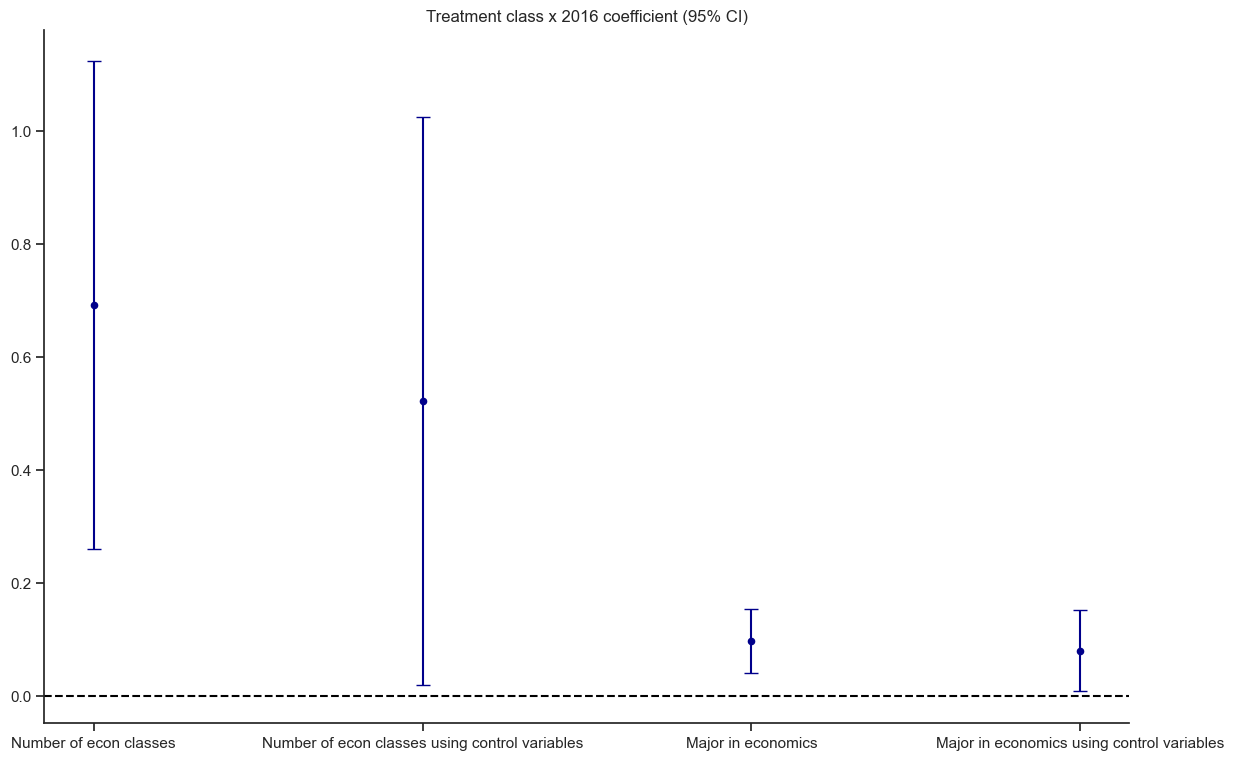

In [19]:
fig, ax = plt.subplots(figsize=(14, 9))

# scatter plot ( para los points . coeficciente)

ax.scatter(x=table_pandas['Model'], 
         marker='o', s=20,  # s: modificar tamaño del point
         y=table_pandas['Estimate'], color = "darkblue")

# errorbar para graficar el itervalo de confianza 

eb1 = plt.errorbar(x=table_pandas['Model'], y=table_pandas['Estimate'],
            yerr = 0.5*(table_pandas['Upper_bound']- table_pandas['Lower_bound']),
            color = 'darkblue', ls='', capsize = 5)



plt.axhline(y=0, color = 'black').set_linestyle('--')  # linea horizontal 

# Set title & labels
plt.title('Treatment class x 2016 coefficient (95% CI)',fontsize=12)

# Guardar el gráfico en un archivo de imagen
plt.savefig(r"..\..\Trabajo_final\Grupo2\graph_treat2016.png")  

# 2. Web Scrapping

## 2.1 Historial de elecciones en Venezuela (Web Scrapping estático)

In [2]:
import pandas as pd
import lxml

from selenium import webdriver  # Nos permite navegar en la web
import re  # regrex
import time  # control del tiempo 
import unidecode # tiene muchas utilidades pero lo utilizaremos para retirar tildes 
from selenium.webdriver.support.ui import Select  # selccionar opciones de las lista desplegable
from selenium.webdriver.common.by import By  # permite seleccionar los elementos en un html
from selenium.webdriver.common.keys import Keys  # ingresar datos a un formulario
from selenium.common.exceptions import NoSuchElementException
from tqdm import tqdm # contabilizar tiempo en el loop
from selenium.webdriver.common.action_chains import ActionChains # movilizar la pantalla


# simulador de webdriver 
from webdriver_manager.chrome import ChromeDriverManager # usar diferentes versiones del browser

import warnings
warnings.filterwarnings('ignore') # eliminar warning messages 

In [3]:
#driver = webdriver.Chrome( ChromeDriverManager().install() )
driver = webdriver.Chrome("chromedriver.exe")



driver.maximize_window()

url = 'https://venezuela360.org/arcgis/apps/sites/#/infraestructura-geoespacial/datasets/3d0308d198ba422fbdabd2e1859eb577/data'

driver.get( url )

In [4]:
table_html = driver.find_element(By.ID, "ember114").get_attribute('innerHTML')
table_html

'<div class="btn-toolbar" aria-live="polite" role="toolbar">\n  <h4 class="table-header pull-left flip">\n    Mostrando 1 a 10 de 13.183\n  </h4>\n<!----></div>\n  <div class="pull-right flip filter-hint">\n    <span class="sr-only">Seleccione un filtro para filtrar las columnas y un nombre de columna para colocar en orden ascendente o descendente</span>\n    Sugerencia: Filtrar columnas con<svg draggable="auto" aria-label="Filtrar" style="" id="ember115" class="svgstore-image ember-view"><!----><use xlink:href="#ember-arcgis-hub-components-hub-icons-filter"></use>\n<!----></svg>\n  </div>\n<div class="clearfix"></div>\n<div class="table-responsive">\n  <table class="table table-striped table-bordered table-hover" role="grid">\n    <thead role="rowgroup">\n      <tr role="row">\n          <th id="ember117" class="ember-view"><button style="touch-action: manipulation; -ms-touch-action: manipulation; cursor: pointer;" aria-labelledby="ember117" aria-label="Filtrar" id="ember118" class="b

In [5]:
table = pd.read_html(table_html)
table

[   Abstencion2000  Abstencion2001  Abstencion2006  Abstencion2007  \
 0               0             927             650             965   
 1               0            1144             546             891   
 2               0            1217             650             878   
 3               0            1556             512             718   
 4               0            1904             867            1254   
 5               0             307             129             193   
 6               0             547             416             590   
 7               0            2065             829            1282   
 8               0             130              58             110   
 9               0             818             400             563   
 
    Abstencion2008  Abstencion2009  Abstencion2010  Abstencion2012  \
 0             999             660             821             474   
 1            1060             773            1195             617   
 2            1015

In [6]:
table[0]

,Abstencion2000,Abstencion2001,Abstencion2006,Abstencion2007,Abstencion2008,Abstencion2009,Abstencion2010,Abstencion2012,Abstencion2013,Abstencion2015,...,Votos2008,Votos2009,Votos2010,Votos2012,Votos2013,Votos2015,win2006,Winner2006,winnerSwing,OBJECTID1
0,0,927,650,965,999,660,821,474,497,521,...,1349,1679,1437,1723,1700,1522,563,Oficialismo,Unidad,1
1,0,1144,546,891,1060,773,1195,617,645,728,...,1431,1690,1571,1996,1968,1570,95,Oficialismo,Unidad,2
2,0,1217,650,878,1015,743,853,599,664,850,...,1379,1623,1526,2013,1948,1835,76,Oficialismo,Unidad,3
3,0,1556,512,718,792,505,619,951,978,1035,...,973,1251,1117,1990,1963,1815,313,Oficialismo,Unidad,4
4,0,1904,867,1254,1579,995,1266,854,907,1435,...,3354,3815,3945,4439,4386,4094,-1431,Unidad,Unidad,5
5,0,307,129,193,238,151,201,151,155,235,...,565,639,708,800,796,782,-206,Unidad,Unidad,6
6,0,547,416,590,596,457,477,332,345,439,...,1134,1246,1141,1177,1164,1008,-634,Unidad,Unidad,7
7,0,2065,829,1282,1476,956,1217,920,1030,1366,...,2906,3356,3220,4172,4062,3540,-1011,Unidad,Unidad,8
8,0,130,58,110,137,97,114,64,68,85,...,188,226,210,264,260,227,175,Oficialismo,Unidad,9
9,0,818,400,563,664,416,523,386,410,599,...,1671,1882,1925,2171,2147,2003,-767,Unidad,Unidad,10


In [7]:
#Consigue el número de paginas
driver.find_element(By.XPATH, "//a[@aria-label='Última página']").click()
time.sleep(1)

In [8]:
numeroPaginas = int(driver.find_element(By.XPATH, '//*[@id="ember114"]/nav/ul/li[8]/a').text)
numeroPaginas


1319

In [9]:
numeroPaginas=numeroPaginas-1

numeroPaginas

1318

In [10]:
#Regresa a la primera pagina
driver.find_element(By.XPATH, "//a[@aria-label='Primera página']").click()
time.sleep(1)

In [11]:
# dict para almacenar los tables 

all_tables = {}

for i in tqdm(range(numeroPaginas)):
    
    table_html = driver.find_element(By.ID, "ember114").get_attribute('innerHTML')
    table = pd.read_html(table_html)
    table = table[0]
    all_tables[f"table_page_{i}"] = table  # llena el diccionario 
    driver.find_element(By.XPATH, "//a[@aria-label='Siguiente']").click()
    time.sleep(2)

    


100%|██████████| 1318/1318 [47:37<00:00,  2.17s/it]


In [12]:
all_tables.keys()

dict_keys(['table_page_0', 'table_page_1', 'table_page_2', 'table_page_3', 'table_page_4', 'table_page_5', 'table_page_6', 'table_page_7', 'table_page_8', 'table_page_9', 'table_page_10', 'table_page_11', 'table_page_12', 'table_page_13', 'table_page_14', 'table_page_15', 'table_page_16', 'table_page_17', 'table_page_18', 'table_page_19', 'table_page_20', 'table_page_21', 'table_page_22', 'table_page_23', 'table_page_24', 'table_page_25', 'table_page_26', 'table_page_27', 'table_page_28', 'table_page_29', 'table_page_30', 'table_page_31', 'table_page_32', 'table_page_33', 'table_page_34', 'table_page_35', 'table_page_36', 'table_page_37', 'table_page_38', 'table_page_39', 'table_page_40', 'table_page_41', 'table_page_42', 'table_page_43', 'table_page_44', 'table_page_45', 'table_page_46', 'table_page_47', 'table_page_48', 'table_page_49', 'table_page_50', 'table_page_51', 'table_page_52', 'table_page_53', 'table_page_54', 'table_page_55', 'table_page_56', 'table_page_57', 'table_page_5

In [13]:
#Se presenta la tabla total
total_data = pd.concat( all_tables.values() ).reset_index( drop = True )
total_data

,Abstencion2000,Abstencion2001,Abstencion2006,Abstencion2007,Abstencion2008,Abstencion2009,Abstencion2010,Abstencion2012,Abstencion2013,Abstencion2015,...,Votos2008,Votos2009,Votos2010,Votos2012,Votos2013,Votos2015,win2006,Winner2006,winnerSwing,OBJECTID1
0,0,927,650,965,999,660,821,474,497,521,...,1349,1679,1437,1723,1700,1522,563.0,Oficialismo,Unidad,1
1,0,1144,546,891,1060,773,1195,617,645,728,...,1431,1690,1571,1996,1968,1570,95.0,Oficialismo,Unidad,2
2,0,1217,650,878,1015,743,853,599,664,850,...,1379,1623,1526,2013,1948,1835,76.0,Oficialismo,Unidad,3
3,0,1556,512,718,792,505,619,951,978,1035,...,973,1251,1117,1990,1963,1815,313.0,Oficialismo,Unidad,4
4,0,1904,867,1254,1579,995,1266,854,907,1435,...,3354,3815,3945,4439,4386,4094,-1431.0,Unidad,Unidad,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13175,1862,1518,1190,1714,1387,1312,1480,941,900,1145,...,3768,3830,3679,4204,4245,4137,NaN,NaN,Unidad,13176
13176,532,444,221,439,343,312,385,236,276,303,...,997,1025,1108,1385,1345,1192,NaN,NaN,Unidad,13177
13177,870,728,400,682,645,541,631,490,381,506,...,1819,1917,1987,2080,2189,2083,NaN,NaN,Unidad,13178
13178,325,271,12,61,120,96,170,124,135,214,...,834,859,873,1057,1046,1108,NaN,NaN,Unidad,13179
